In [5]:
import numpy as np
import matplotlib.pyplot as plt 
from keras.models import load_model
from matplotlib import cm
def loadArray(case,field):
    data = np.load('/home/haoyan/Desktop/ML-CFD/dataset/archive/'+dataset+'/'+dataset+'_'+case+'_'+field + '.npy')
    return data
def loadLabels(case,field):
    data = np.load('/home/haoyan/Desktop/ML-CFD/dataset/archive/'+'labels/'+case+'_'+field + '.npy')
    return data
dataset = 'komega'
case = 'CNDV_12600'

def Stra_Rota(tensor,k,epsilon):#Forming non-dimensional strain tensor and rotation tensor
    number = len(tensor)
    s = np.zeros((number,3,3))
    w = np.zeros((number,3,3))
    for i in range(number):
        coef = k[i] / epsilon[i]
        s[i] = coef * (tensor[i] + tensor[i].T)/2
        w[i] = coef * (tensor[i] - tensor[i].T)/2
    return s,w

def Invariants1(s,w):#Forming 5 Invariants according to Pope(1975)
    number = len(s)
    l_1 = np.zeros(number)
    l_2 = np.zeros(number)
    l_3 = np.zeros(number)
    l_4 = np.zeros(number)
    l_5 = np.zeros(number)
    for i in range(number):
        tmp_1 = s[i]@s[i]
        tmp_2 = w[i]@w[i]
        tmp_3 = s[i]@s[i]@s[i]
        tmp_4 = w[i]@w[i]@s[i]
        tmp_5 = w[i]@w[i]@s[i]@s[i]
        l_1[i] = tmp_1.trace()
        l_2[i] = tmp_2.trace()
        l_3[i] = tmp_3.trace()
        l_4[i] = tmp_4.trace()
        l_5[i] = tmp_5.trace()
    return l_1,l_2,l_3,l_4,l_5

def General_Tensors(s,w):#Forming 10 general tensors according to Pope(1975)
    number = len(s)
    T_1 = np.zeros((number,3,3))
    T_2 = np.zeros((number,3,3))
    T_3 = np.zeros((number,3,3))
    T_4 = np.zeros((number,3,3))
    T_5 = np.zeros((number,3,3))
    T_6 = np.zeros((number,3,3))
    T_7 = np.zeros((number,3,3))
    T_8 = np.zeros((number,3,3))
    T_9 = np.zeros((number,3,3))
    T_10 = np.zeros((number,3,3))
    for i in range(number):
        tmp_1 = s[i]@s[i]
        tmp_2 = w[i]@w[i]
        tmp_3 = s[i]@w[i]@w[i]
        tmp_4 = s[i]@s[i]@w[i]@w[i]
        T_1[i] = s[i]
        T_2[i] = s[i]@w[i] - w[i]@s[i]
        T_3[i] = s[i]@s[i] - (1/3) * np.eye(3) * tmp_1.trace() 
        T_4[i] = w[i]@w[i] - (1/3) * np.eye(3) * tmp_2.trace()
        T_5[i] = w[i]@s[i]@s[i] - s[i]@s[i]@w[i]
        T_6[i] = w[i]@w[i]@s[i] + s[i]@w[i]@w[i] - (2/3) * np.eye(3) * tmp_3.trace()
        T_7[i] = w[i]@s[i]@w[i]@w[i] - w[i]@w[i]@s[i]@w[i]
        T_8[i] = s[i]@w[i]@s[i]@s[i] - s[i]@s[i]@w[i]@s[i]
        T_9[i] = w[i]@w[i]@s[i]@s[i] + s[i]@s[i]@w[i]@w[i] - 2/3 * np.eye(3)*tmp_4.trace()
        T_10[i] = w[i]@s[i]@s[i]@w[i]@w[i] - w[i]@w[i]@s[i]@s[i]@w[i]
    return T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10
def plot_contour(x_coordinate,y_coordinate,i,j,field,field_name,bar_numbers,Min,Max):
    X = np.zeros((j,i))
    Y = np.zeros((j,i))
    Field = np.zeros((j,i))
    for n in range(j):
        X[n,:] = x_coordinate[i*n:i*(n+1)]
        Y[n,:] = y_coordinate[i*n:i*(n+1)]
        Field[n,:] = field[i*n:i*(n+1)]
    fig,ax = plt.subplots(figsize=(20,7.5))
    levels = list(np.linspace(Min,Max,bar_numbers))
    p1 = ax.contourf(X,Y,Field,levels,cmap=cm.jet,extend='both')
    p2 = ax.contour(X,Y,Field,levels,linewidths=0.5,colors='black',extend='both')
    ax.set_xlim(min(x_coordinate), max(x_coordinate))
    ax.set_ylim(min(y_coordinate), max(y_coordinate))
    ax.set_xlabel("$\t{x}$(mm)",size=15)
    ax.set_ylabel("$\t{y}$(mm)",size=15)
    cbar = fig.colorbar(p1)
    cbar.set_label(field_name, size=18)
    plt.show()
    return 0
def make_realizable(label):
        """
        This function is specific to turbulence modeling.
        Given the anisotropy tensor, this function forces realizability
        by shifting values within acceptable ranges for Aii > -1/3 and 2|Aij| < Aii + Ajj + 2/3
        Then, if eigenvalues negative, shifts them to zero. Noteworthy that this step can undo
        constraints from first step, so this function should be called iteratively to get convergence
        to a realizable state.
        :param labels: the predicted anisotropy tensor (num_points X 9 array)
        """
        numPoints = label.shape[0]
        labels = np.zeros((numPoints,9))
        for i in range(numPoints):
            labels[i][0] = label[i][0]
            labels[i][1] = label[i][1]
            labels[i][2] = label[i][2]
            labels[i][3] = label[i][1]
            labels[i][4] = label[i][3]
            labels[i][5] = label[i][4]
            labels[i][6] = label[i][2]
            labels[i][7] = label[i][4]
            labels[i][8] = label[i][5]
        A = np.zeros((3, 3))
        for i in range(numPoints):
            # Scales all on-diags to retain zero trace
            if np.min(labels[i, [0, 4, 8]]) < -1./3.:
                labels[i, [0, 4, 8]] *= -1./(3.*np.min(labels[i, [0, 4, 8]]))
            if 2.*np.abs(labels[i, 1]) > labels[i, 0] + labels[i, 4] + 2./3.:
                labels[i, 1] = (labels[i, 0] + labels[i, 4] + 2./3.)*.5*np.sign(labels[i, 1])
                labels[i, 3] = (labels[i, 0] + labels[i, 4] + 2./3.)*.5*np.sign(labels[i, 1])
            if 2.*np.abs(labels[i, 5]) > labels[i, 4] + labels[i, 8] + 2./3.:
                labels[i, 5] = (labels[i, 4] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 5])
                labels[i, 7] = (labels[i, 4] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 5])
            if 2.*np.abs(labels[i, 2]) > labels[i, 0] + labels[i, 8] + 2./3.:
                labels[i, 2] = (labels[i, 0] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 2])
                labels[i, 6] = (labels[i, 0] + labels[i, 8] + 2./3.)*.5*np.sign(labels[i, 2])

            # Enforce positive semidefinite by pushing evalues to non-negative
            A[0, 0] = labels[i, 0]
            A[1, 1] = labels[i, 4]
            A[2, 2] = labels[i, 8]
            A[0, 1] = labels[i, 1]
            A[1, 0] = labels[i, 1]
            A[1, 2] = labels[i, 5]
            A[2, 1] = labels[i, 5]
            A[0, 2] = labels[i, 2]
            A[2, 0] = labels[i, 2]
            evalues, evectors = np.linalg.eig(A)
            if np.max(evalues) < (3.*np.abs(np.sort(evalues)[1])-np.sort(evalues)[1])/2.:
                evalues = evalues*(3.*np.abs(np.sort(evalues)[1])-np.sort(evalues)[1])/(2.*np.max(evalues))
                A = np.dot(np.dot(evectors, np.diag(evalues)), np.linalg.inv(evectors))
                for j in range(3):
                    labels[i, j] = A[j, j]
                labels[i, 1] = A[0, 1]
                labels[i, 5] = A[1, 2]
                labels[i, 2] = A[0, 2]
                labels[i, 3] = A[0, 1]
                labels[i, 7] = A[1, 2]
                labels[i, 6] = A[0, 2]
            if np.max(evalues) > 1./3. - np.sort(evalues)[1]:
                evalues = evalues*(1./3. - np.sort(evalues)[1])/np.max(evalues)
                A = np.dot(np.dot(evectors, np.diag(evalues)), np.linalg.inv(evectors))
                for j in range(3):
                    labels[i, j] = A[j, j]
                labels[i, 1] = A[0, 1]
                labels[i, 5] = A[1, 2]
                labels[i, 2] = A[0, 2]
                labels[i, 3] = A[0, 1]
                labels[i, 7] = A[1, 2]
                labels[i, 6] = A[0, 2]
                
        labels_6 = np.zeros((numPoints,6))
        for i in range(numPoints):
            labels_6[i][0] = labels[i][0]
            labels_6[i][1] = labels[i][1]
            labels_6[i][2] = labels[i][2]
            labels_6[i][3] = labels[i][4]
            labels_6[i][4] = labels[i][5]
            labels_6[i][5] = labels[i][8]
        return labels_6

In [2]:
x = loadArray(case,'Cx')
y = loadArray(case,'Cy')
gradU = loadArray(case,'gradU')
k = loadArray(case,'k')
epsilon = loadArray(case,'epsilon')
s,w = Stra_Rota(gradU,k,epsilon)
I_1,I_2,I_3,I_4,I_5 = Invariants1(s,w) #Invariants//verified
T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9,T_10 = General_Tensors(s,w)
I1 = np.column_stack((I_1,I_2,I_3,I_4,I_5))
Tensors = np.zeros((len(k),10,3,3))
for i in range(len(k)):
    Tensors[i][0] = T_1[i]
    Tensors[i][1] = T_2[i]
    Tensors[i][2] = T_3[i]
    Tensors[i][3] = T_4[i]
    Tensors[i][4] = T_5[i]
    Tensors[i][5] = T_6[i]
    Tensors[i][6] = T_7[i]
    Tensors[i][7] = T_8[i]
    Tensors[i][8] = T_9[i]
    Tensors[i][9] = T_10[i]

In [3]:
model = load_model("/home/haoyan/Desktop/ML-CFD/covdiv-pope.h5")

2022-06-27 16:09:24.423563: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-27 16:09:24.423588: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-27 16:09:24.423605: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cute): /proc/driver/nvidia/version does not exist
2022-06-27 16:09:24.424368: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
b_p = model.predict([I1,Tensors])

2022-06-27 16:09:28.874314: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35532000 exceeds 10% of free system memory.


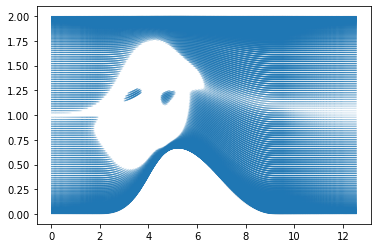

In [49]:
plt.scatter(x,y,b_p[:,0])

In [50]:
b_p = make_realizable(b_p)

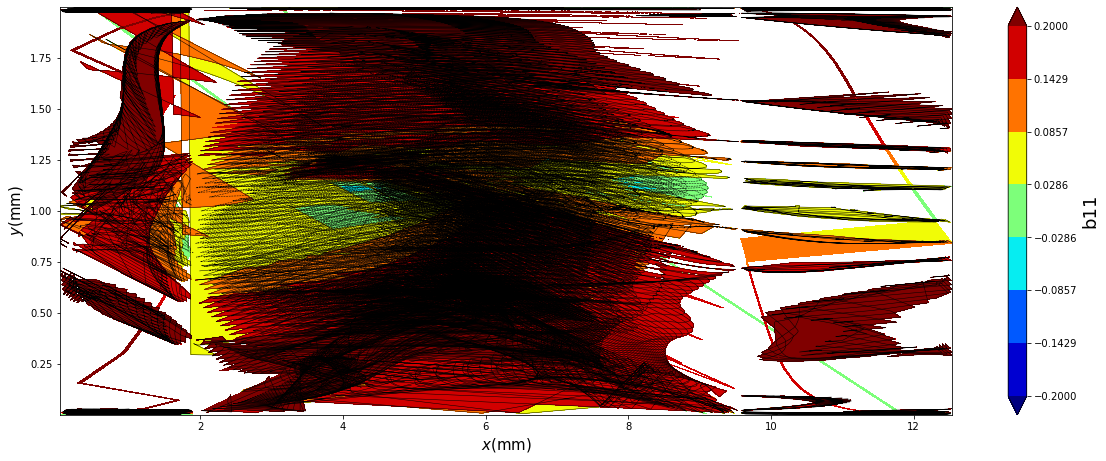

0

In [16]:
plot_contour(x,y,564,175,b_p[:,0],'b11',8,-0.2,0.2)

In [15]:
def field_output(field,field_name):
    bij_field = ''
    for i in range(len(field)):
        bij_field += f'({field[i][0]} {field[i][1]} {field[i][2]} {field[i][3]} {field[i][4]} {field[i][5]})\n'
    file_template = f'''/*--------------------------------*- C++ -*----------------------------------*\
    | =========                 |                                                 |
    | \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
    |  \\    /   O peration     | Version:  v2012                                 |
    |   \\  /    A nd           | Website:  www.openfoam.com                      |
    |    \\/     M anipulation  |                                                 |
    \*---------------------------------------------------------------------------*/
    FoamFile
    {{
        version     2.0;
        format      ascii;
        class       volSymmTensorField;
        location    "0";
        object      bij;
    }}
    // * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //
    dimensions      [0 0 0 0 0 0 0];
    internalField   nonuniform List<symmTensor> 
    {field.shape[0]}
    (
    {bij_field}
    )
    ;
    boundaryField
    {{
        inlet
        {{
            type            zeroGradient;
        }}
        outlet
        {{
            type            zeroGradient;
        }}
        bottom
        {{
            type            fixedValue;
            value           uniform (0 0 0 0 0 0);
        }}
        top
        {{
            type            fixedValue;
            value           uniform (0 0 0 0 0 0);
        }}
        frontAndBack
        {{
            type            empty;
        }}
    }}
    // ************************************************************************* //'''

    # Saving b_ij as a text file
    with open(field_name, 'w') as file:
        file.write(file_template)